# AWS 환경설정

* `export AWS_DEFAULT_PROFILE=ghpipeliner` 실행
* 원하는 aws profile로 잘 변경되었는지 확인
    ```
    aws s3 ls
    ```

In [1]:
import boto3
import pandas as pd
import numpy as np
import json

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta

# Load Data

In [2]:
session = boto3.session.Session(profile_name='ghpipeliner')
s3 = session.client('s3')

In [3]:
from_dt = datetime(2023, 1, 2)
to_dt = datetime(2023, 1, 14)

dt = from_dt
df = pd.DataFrame()
cols = ['candle_date_time_kst', 'open', 'high', 'low', 'close', 'volume']
while(dt <= to_dt):
    print(f"Reading {dt}...")
    for hr in range(24):
        file_name = f'{dt + timedelta(hours=hr, minutes=5, seconds=1)} candles.json'
        try:
            response = s3.get_object(Bucket='hb-ohlcv-buy-or-sell', Key=file_name)
        except:
            file_name = f'{dt + timedelta(hours=hr, minutes=5, seconds=2)} candles.json'
            response = s3.get_object(Bucket='hb-ohlcv-buy-or-sell', Key=file_name)
        obj = json.loads(response['Body'].read().decode('utf-8'))
        df = pd.concat([df, pd.DataFrame(obj['candles'])[cols]])
    dt = dt + timedelta(days=1)
    
df.reset_index(drop=True, inplace=True)
df['candle_date_time_kst'] = df['candle_date_time_kst'].astype(dtype=np.datetime64)
df

Reading 2023-01-02 00:00:00...
Reading 2023-01-03 00:00:00...
Reading 2023-01-04 00:00:00...
Reading 2023-01-05 00:00:00...
Reading 2023-01-06 00:00:00...
Reading 2023-01-07 00:00:00...
Reading 2023-01-08 00:00:00...
Reading 2023-01-09 00:00:00...
Reading 2023-01-10 00:00:00...
Reading 2023-01-11 00:00:00...
Reading 2023-01-12 00:00:00...
Reading 2023-01-13 00:00:00...
Reading 2023-01-14 00:00:00...


,candle_date_time_kst,open,high,low,close,volume
0,2023-01-01 23:06:00,21088000.0,21088000.0,21088000.0,21088000.0,0.055518
1,2023-01-01 23:07:00,21088000.0,21099000.0,21088000.0,21088000.0,0.386599
2,2023-01-01 23:08:00,21088000.0,21099000.0,21088000.0,21099000.0,0.097290
3,2023-01-01 23:09:00,21098000.0,21099000.0,21089000.0,21091000.0,0.415292
4,2023-01-01 23:10:00,21099000.0,21099000.0,21090000.0,21099000.0,0.299756
...,...,...,...,...,...,...
18715,2023-01-14 23:01:00,25982000.0,25988000.0,25969000.0,25984000.0,23.919694
18716,2023-01-14 23:02:00,25981000.0,26000000.0,25971000.0,25971000.0,20.102817
18717,2023-01-14 23:03:00,25971000.0,25980000.0,25943000.0,25948000.0,11.595073
18718,2023-01-14 23:04:00,25948000.0,25976000.0,25940000.0,25970000.0,17.004231


# Preprocess Data
* n분후 `상승` or `하락` 예측 (`유지`도 상승에 포함)

In [4]:
n = 15
df['target'] = df.shift(-n)['close']
df.loc[df['target'] < df['close'], 'target'] = 0  # 순서 주의
df.loc[df['target'] >= df['close'], 'target'] = 1 # 순서 주의
data = df.iloc[:len(df) - n]
data

,candle_date_time_kst,open,high,low,close,volume,target
0,2023-01-01 23:06:00,21088000.0,21088000.0,21088000.0,21088000.0,0.055518,1.0
1,2023-01-01 23:07:00,21088000.0,21099000.0,21088000.0,21088000.0,0.386599,1.0
2,2023-01-01 23:08:00,21088000.0,21099000.0,21088000.0,21099000.0,0.097290,0.0
3,2023-01-01 23:09:00,21098000.0,21099000.0,21089000.0,21091000.0,0.415292,1.0
4,2023-01-01 23:10:00,21099000.0,21099000.0,21090000.0,21099000.0,0.299756,0.0
...,...,...,...,...,...,...,...
18700,2023-01-14 22:46:00,25902000.0,25936000.0,25902000.0,25936000.0,10.017290,1.0
18701,2023-01-14 22:47:00,25918000.0,25933000.0,25908000.0,25910000.0,6.703668,1.0
18702,2023-01-14 22:48:00,25910000.0,25950000.0,25878000.0,25945000.0,24.123577,1.0
18703,2023-01-14 22:49:00,25940000.0,25964000.0,25936000.0,25962000.0,36.878548,1.0


In [5]:
data_train = data.iloc[:int(len(data) * 0.8)]
data_test = data.iloc[int(len(data) * 0.8):]

print('Data for Modeling: ', str(data_train.shape))
print('Unseen Data for Predictions: ', str(data_test.shape))

Data for Modeling:  (14964, 7)
Unseen Data for Predictions:  (3741, 7)


# Train Model

* pycaret sample notebook: [classification beginer tutorial](https://nbviewer.org/github/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20-%20Level%20Beginner.ipynb)

In [6]:
from pycaret.classification import *

In [7]:
exp_reg001 = setup(data=data_train, target='target', session_id=1)

,Description,Value
0,session_id,1
1,Target,target
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(14964, 7)"
5,Missing Values,0
6,Numeric Features,5
7,Categorical Features,0
8,Ordinal Features,0
9,High Cardinality Features,0


In [8]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5818,0.6046,0.7208,0.5953,0.6520,0.1399,0.1440,0.0270
gbc,Gradient Boosting Classifier,0.5744,0.5895,0.8360,0.5746,0.6810,0.1032,0.1212,0.1490
knn,K Neighbors Classifier,0.5691,0.5796,0.6280,0.5988,0.6130,0.1276,0.1279,0.0360
ada,Ada Boost Classifier,0.5575,0.5527,0.7884,0.5668,0.6592,0.0736,0.0830,0.0570
lr,Logistic Regression,0.5572,0.5530,0.7654,0.5688,0.6525,0.0772,0.0843,0.5360
nb,Naive Bayes,0.5570,0.5522,0.6082,0.5900,0.5987,0.1045,0.1047,0.0050
ridge,Ridge Classifier,0.5563,0.0000,0.7624,0.5684,0.6511,0.0758,0.0826,0.0050
lda,Linear Discriminant Analysis,0.5562,0.5530,0.7610,0.5685,0.6507,0.0758,0.0826,0.0190
rf,Random Forest Classifier,0.5507,0.5717,0.5875,0.5867,0.5870,0.0944,0.0944,0.1840
et,Extra Trees Classifier,0.5496,0.5644,0.5841,0.5861,0.5850,0.0927,0.0927,0.2070


In [9]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5391,0.5501,0.6754,0.5637,0.6145,0.0530,0.0544
1,0.5954,0.6121,0.7368,0.6052,0.6646,0.1671,0.1723
2,0.5811,0.6158,0.6982,0.5985,0.6445,0.1419,0.1445
3,0.6078,0.6348,0.7421,0.6157,0.6730,0.1936,0.1989
4,0.5750,0.5851,0.7047,0.5914,0.6431,0.1276,0.1306
5,0.6027,0.6244,0.7434,0.6104,0.6704,0.1823,0.1880
6,0.5712,0.5830,0.7153,0.5865,0.6445,0.1173,0.1210
7,0.5673,0.5896,0.7083,0.5841,0.6402,0.1101,0.1133
8,0.6084,0.6534,0.7452,0.6154,0.6741,0.1947,0.2003


In [10]:
tuned_lgbm = tune_model(lgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5429,0.5298,0.7965,0.5557,0.6547,0.0387,0.0445
1,0.5582,0.5536,0.8193,0.5647,0.6686,0.0692,0.0808
2,0.5725,0.5774,0.8316,0.5738,0.6791,0.0995,0.1160
3,0.5611,0.5571,0.7807,0.5705,0.6593,0.0828,0.0912
4,0.5530,0.5375,0.8049,0.5620,0.6618,0.0606,0.0696
5,0.5635,0.5582,0.8313,0.5671,0.6743,0.0796,0.0941
6,0.5673,0.5678,0.8207,0.5709,0.6734,0.0902,0.1041
7,0.5578,0.5530,0.7944,0.5664,0.6613,0.0733,0.0825
8,0.5817,0.6060,0.8278,0.5808,0.6826,0.1214,0.1388


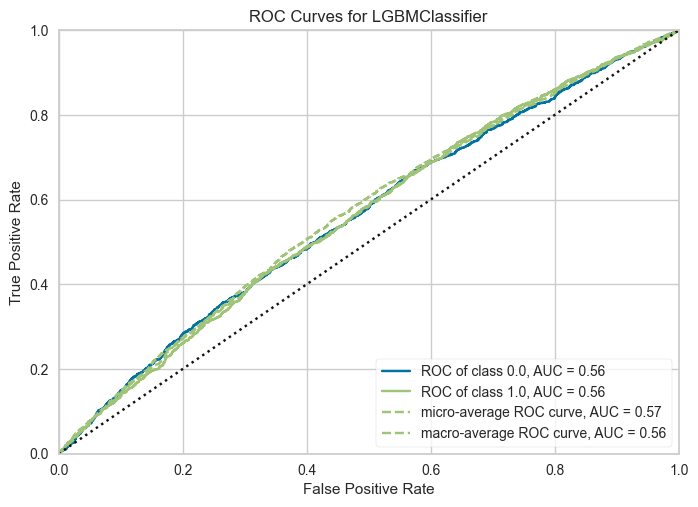

In [11]:
plot_model(tuned_lgbm)

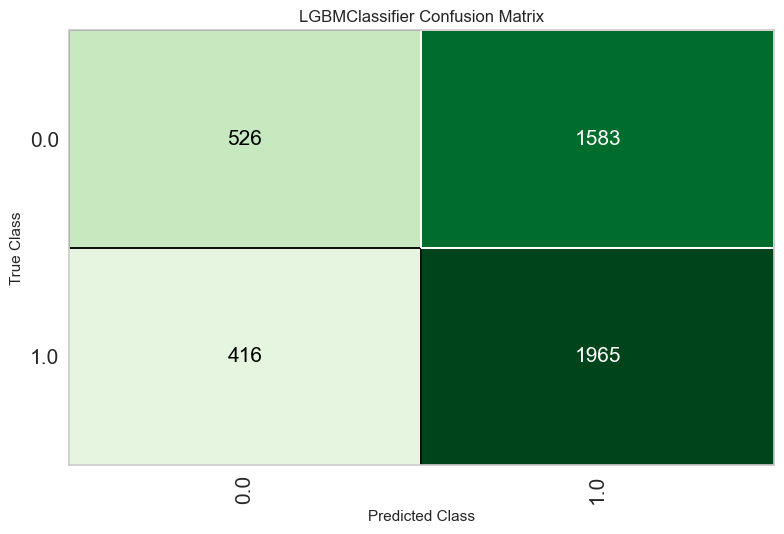

In [12]:
plot_model(tuned_lgbm, plot = 'confusion_matrix')

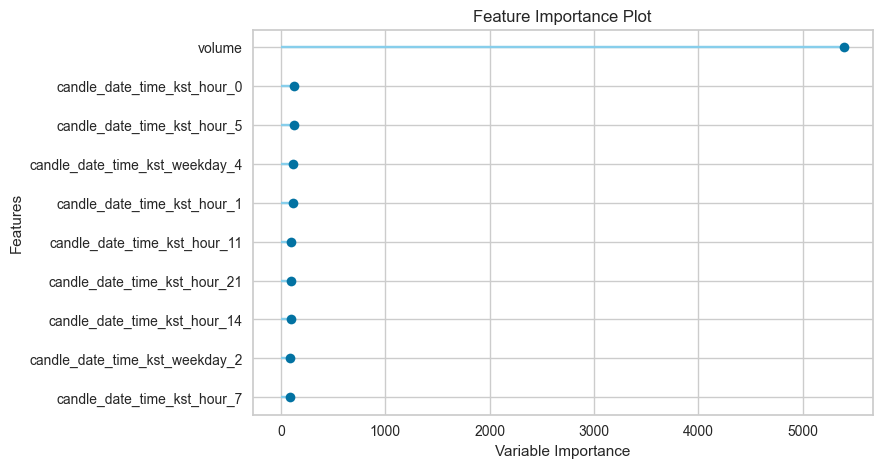

In [13]:
plot_model(tuned_lgbm, plot='feature')

In [14]:
final_lgbm = finalize_model(tuned_lgbm)
print(final_lgbm)

[LightGBM] [Warning] [LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5[LightGBM] [Warning] 
feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5[LightGBM] [Warning] 
bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6[LightGBM] [Warning] 
bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will b

In [15]:
unseen_predictions = predict_model(final_lgbm, data=data_test)
unseen_predictions.head(10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.5523,0.5295,0.6659,0.6166,0.6403,0.0497,0.0500


,candle_date_time_kst,open,high,low,close,volume,target,Label,Score
14964,2023-01-12 08:30:00,22132000.0,22163000.0,22120000.0,22163000.0,2.863706,1.0,1.0,0.6234
14965,2023-01-12 08:31:00,22163000.0,22167000.0,22161000.0,22162000.0,6.822875,1.0,1.0,0.5745
14966,2023-01-12 08:32:00,22162000.0,22240000.0,22161000.0,22230000.0,36.114889,1.0,1.0,0.5132
14967,2023-01-12 08:33:00,22230000.0,22415000.0,22224000.0,22403000.0,60.997269,1.0,1.0,0.5132
14968,2023-01-12 08:34:00,22400000.0,22498000.0,22377000.0,22475000.0,27.666239,0.0,1.0,0.5132
14969,2023-01-12 08:35:00,22473000.0,22498000.0,22415000.0,22432000.0,34.066196,1.0,1.0,0.5132
14970,2023-01-12 08:36:00,22419000.0,22460000.0,22419000.0,22448000.0,36.027856,1.0,1.0,0.5132
14971,2023-01-12 08:37:00,22439000.0,22501000.0,22437000.0,22492000.0,34.359781,0.0,1.0,0.5132
14972,2023-01-12 08:38:00,22499000.0,22499000.0,22449000.0,22470000.0,13.902834,0.0,1.0,0.5132
14973,2023-01-12 08:39:00,22470000.0,22470000.0,22401000.0,22422000.0,14.684522,1.0,1.0,0.5132


In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [17]:
unseen_predictions['close'] - unseen_predictions.shift(-n)['close']

14964   -282000.0
14965   -289000.0
14966   -219000.0
14967    -48000.0
14968     38000.0
           ...   
18700         NaN
18701         NaN
18702         NaN
18703         NaN
18704         NaN
Name: close, Length: 3741, dtype: float64

In [18]:
(unseen_predictions['Label'].astype(float) - 0.5) * 30000

14964    15000.0
14965    15000.0
14966    15000.0
14967    15000.0
14968    15000.0
          ...   
18700    15000.0
18701    15000.0
18702    15000.0
18703    15000.0
18704    15000.0
Name: Label, Length: 3741, dtype: float64

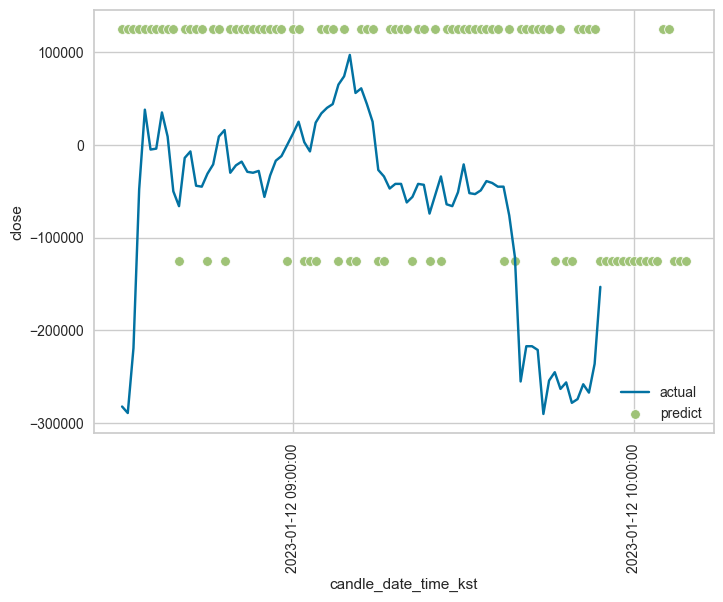

In [19]:
fig, ax = plt.subplots()

to_see_data = unseen_predictions.head(100)

sns.lineplot(x=to_see_data['candle_date_time_kst'], y=to_see_data['close'] - to_see_data.shift(-n)['close'], label='actual', ax=ax)
sns.scatterplot(x=to_see_data['candle_date_time_kst'], y=(to_see_data['Label'].astype(float) - 0.5) * 250000, label='predict', ax=ax, color = 'g')

ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
ax.set_xticklabels(labels=ax.xaxis.get_ticklabels(), rotation=90)
fig.show()

In [20]:
from sklearn.metrics import confusion_matrix

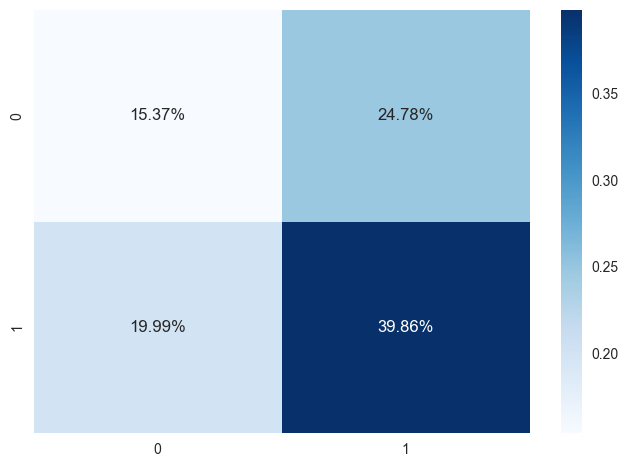

In [21]:
cf_matrix = confusion_matrix(unseen_predictions['target'].astype(float), unseen_predictions['Label'].astype(float))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

In [24]:
create_api(final_lgbm, 'lgbm_api')


API sucessfully created. This function only creates a POST API, it doesn't run it automatically.

To run your API, please run this command --> !python lgbm_api.py
    


In [25]:
create_docker('lgbm_api')

Writing requirements.txt
Writing Dockerfile
Dockerfile and requirements.txt successfully created.
To build image you have to run --> !docker image build -f "Dockerfile" -t IMAGE_NAME:IMAGE_TAG .
        


```
docker image build . -t pycaret_lgbm:latest
```

```
docker tag pycaret_lgbm:latest 433166909747.dkr.ecr.ap-northeast-2.amazonaws.com/pycaret_lgbm
aws ecr get-login-password --region ap-northeast-2 | docker login --username AWS --password-stdin 433166909747.dkr.ecr.ap-northeast-2.amazonaws.com
docker push 433166909747.dkr.ecr.ap-northeast-2.amazonaws.com/pycaret_lgbm
```